# Segunda parte: Modelos del lenguaje con RNNs

En esta parte, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar esta actividad con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [0]:
import numpy as np 
import keras
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import random
import io

path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)

Using TensorFlow backend.


2154496/2151176 [==============================] - 1s 1us/step


Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [0]:
## TU CÓDIGO AQUÍ
with open(path, encoding="utf8") as f:
    text = f.read().lower()

Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [0]:
print("Longitud del texto: {}".format(len(text)))
print(text[0:300])

Longitud del texto: 2071198
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot 
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot 
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:
 

1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [0]:
text[0:100]

'capítulo primero. que trata de la condición y ejercicio del famoso hidalgo\ndon quijote de la mancha\n'

In [0]:
## TU CÓDIGO AQUÍ
chars=sorted(set(text))
char_indices = dict((chars[index],index) for index in range(len(chars)))
indice_char = {v: k for k, v in char_indices.items()}

In [0]:
print(len(chars))
print(indice_char)
print(char_indices)

61
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: ':', 19: ';', 20: '?', 21: ']', 22: 'a', 23: 'b', 24: 'c', 25: 'd', 26: 'e', 27: 'f', 28: 'g', 29: 'h', 30: 'i', 31: 'j', 32: 'l', 33: 'm', 34: 'n', 35: 'o', 36: 'p', 37: 'q', 38: 'r', 39: 's', 40: 't', 41: 'u', 42: 'v', 43: 'w', 44: 'x', 45: 'y', 46: 'z', 47: '¡', 48: '«', 49: '»', 50: '¿', 51: 'à', 52: 'á', 53: 'é', 54: 'í', 55: 'ï', 56: 'ñ', 57: 'ó', 58: 'ù', 59: 'ú', 60: 'ü'}
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, ':': 18, ';': 19, '?': 20, ']': 21, 'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46, '¡': 47, '«': 48, '»': 49, '¿': 50, 'à': 

#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [0]:
#print(text[0:33])
print(text[0:30])
print(text[30])

capítulo primero. que trata de
 


In [0]:
pru =[]

In [0]:
print(len(pru))
pru.append(text[30])
print(pru)

0
[' ']


In [0]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []

## TU CÓDIGO AQUÍ
# Realizar un for de 0 hasta tamaño len - seq_length.
for i in range(0,len(text)-SEQ_LENGTH):
    sequences.append(text[i:i+SEQ_LENGTH])
    next_chars.append(text[i+SEQ_LENGTH])
# Llenar sequences y next_chars .append..


In [0]:
print(sequences[0:7])
print(next_chars[0:7])

['capítulo primero. que trata de', 'apítulo primero. que trata de ', 'pítulo primero. que trata de l', 'ítulo primero. que trata de la', 'tulo primero. que trata de la ', 'ulo primero. que trata de la c', 'lo primero. que trata de la co']
[' ', 'l', 'a', ' ', 'c', 'o', 'n']


Indicar el tamaño del training set que acabamos de generar.

In [0]:
## TU CÓDIGO AQUÍ
print("Tamaño de sequencias : ",len(sequences),"Tamaño de los siguientes caracteres : ",len(next_chars))
# Tamaño sequences

Tamaño de sequencias :  2071168 Tamaño de los siguientes caracteres :  2071168


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [0]:
MAX_SEQUENCES = 500000

perm = np.random.permutation(len(sequences)) #Permutar aleatoriamente una secuencia, o devolver un rango permutado.
sequences, next_chars = np.array(sequences), np.array(next_chars) 
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print(len(sequences))

500000


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e **y** tendrá shape *(num_sequences, num_chars)*. 



In [0]:
NUM_CHARS = len(chars)  # Tu número de caracteres distintos aquí. Lo hecho en el 2.1
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS)) 
y = np.zeros((NUM_SEQUENCES, NUM_CHARS))

## Tu código para rellenar X e y aquí. Pista: utilizar el diccionario de
## chars a índices obtenido anteriormente junto con numpy. Por ejemplo,
## si hacemos 
##     X[0, 1, char_to_indices['a']] = 1
## estamos diciendo que para la segunda posición de la primera secuencia se
## tiene una 'a'

## TU CÓDIGO AQUÍ
for i in range(len(sequences)):
    for j in range (SEQ_LENGTH):
        X[i, j, char_indices[sequences[i][j]]] = 1
    y[i,char_indices[next_chars[i]]] = 1
print(sequences[0][0])
print(char_indices[sequences[0][0]])

 
1


In [0]:
print(X[0,0,:])
print(y[0,:])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [0]:
## TU CÓDIGO AQUÍ
model = keras.Sequential()

model.add(keras.layers.LSTM(256,return_sequences=True,input_shape=(SEQ_LENGTH, NUM_CHARS)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(180,return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dropout(0.5))
#model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(NUM_CHARS, activation='softmax'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 30, 256)           325632    
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 256)           1024      
_________________________________________________________________
lstm_29 (LSTM)               (None, 30, 180)           314640    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 180)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 100)               112400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 61)              

In [0]:
model.compile(optimizer='adam', 
             loss='categorical_crossentropy', #la misma función de pérdida que CategoricalCrossentropy pero para problemas de dos clases
             metrics=['accuracy'])

In [0]:
history = model.fit(X,
                   y,
                   epochs=40,
                   batch_size=1024*16)

Epoch 1/40
500000/500000 [==============================] - 29s 59us/step - loss: 3.3657 - accuracy: 0.1277
Epoch 2/40
500000/500000 [==============================] - 28s 57us/step - loss: 3.0042 - accuracy: 0.1924
Epoch 3/40
500000/500000 [==============================] - 28s 57us/step - loss: 2.6397 - accuracy: 0.2648
Epoch 4/40
500000/500000 [==============================] - 28s 57us/step - loss: 2.4306 - accuracy: 0.2949
Epoch 5/40
500000/500000 [==============================] - 28s 57us/step - loss: 2.3299 - accuracy: 0.3151
Epoch 6/40
500000/500000 [==============================] - 28s 57us/step - loss: 2.2597 - accuracy: 0.3294
Epoch 7/40
500000/500000 [==============================] - 28s 57us/step - loss: 2.2044 - accuracy: 0.3422
Epoch 8/40
500000/500000 [==============================] - 28s 57us/step - loss: 2.1548 - accuracy: 0.3549
Epoch 9/40
500000/500000 [==============================] - 28s 57us/step - loss: 2.1119 - accuracy: 0.3660
Epoch 10/40
500000/500000 [=

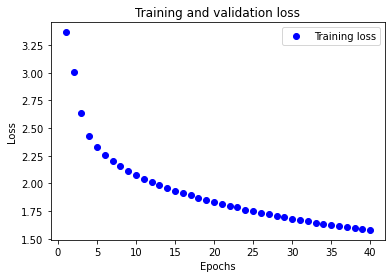

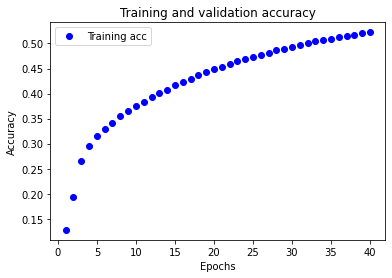

In [0]:
history_dict = history.history #A partir del objeto hystory lo guardamos para graficarlo
history_dict.keys()
#%matplotlib inline

acc= history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss=history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

#bo is for blue dot
plt.plot(epochs, loss, 'bo', label='Training loss')
#b is for solid blue line
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.clf()
acc_values = history_dict['accuracy']
#val_acc_values = history_dict['val_accuracy']

#bo is for blue dot
plt.plot(epochs, acc, 'bo', label='Training acc')
#b is for solid blue line
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [0]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


In [0]:
pru = [indice_char[sample(model.predict(X[i].reshape(1,30,61))[0])] for i in range(10)]
print(pru)

[' ', 's', ' ', 's', 's', 'd', 'o', 'o', 'n', 'a']


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [0]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 300

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = seed_text
    
    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.
    ### TU CÓDIGO AQUÍ

    #print(len(generated))  #30
    aux = ""
    text_new = generated
    for i in range(length):
      new = np.zeros((1,len(text_new),NUM_CHARS))
      for j in range (len(text_new)):
        new[0,j,char_indices[text_new[j]]] = 1
      char_new=indice_char[sample(model.predict(new,verbose=0)[0])]
      text_new = text_new[1:] + char_new
      aux += char_new
    #print(new.shape) ##(1, 30, 61)
    #print(char_new)
    #print("Nuevo text : ",text_new)
    #print("aux : ",aux)

    ### FIN DE TU CÓDIGO
    return generated + aux[1:]


def on_epoch_end(epoch, logs):
  print("\n\n\n")
  
  # Primero, seleccionamos una secuencia al azar para empezar a predecir
  # a partir de ella
  start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
  seed_text = text[start_pos:start_pos + SEQ_LENGTH]
  for temperature in TEMPERATURES_TO_TRY:
    print("------> Epoch: {} - Generando texto con temperature {}".format(
        epoch + 1, temperature))
    
    generated_text = generate_text(seed_text, model, 
                                   GENERATED_TEXT_LENGTH, temperature)
    print("Seed: {}".format(seed_text))
    print("Texto generado: {}".format(generated_text))
    print()


generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  

In [0]:
on_epoch_end(1,1)





------> Epoch: 2 - Generando texto con temperature 0.2
Seed: l
muchas serpientes, culebras 
Texto generado: l
muchas serpientes, culebras ue fel y pojungo, que ey la que fueron a la lotar por entantos enegrecos;
y por seuso;
y coma.
-no de esto que fino; don quijote, por lo de drego ji acabar, pués te cuerpo,
se de que este
so
que duda acoda-, señor con su
como se hijo, al entra: aventura de poernos con traer erranclinó de pensoso de

------> Epoch: 2 - Generando texto con temperature 0.5
Seed: l
muchas serpientes, culebras 
Texto generado: l
muchas serpientes, culebras elamos sé
más deterlantes que al valto que diciendo las más te nuestros
insiarnos espacíanos es un gardominos hablarque no es vodrió el ando el
el guciene.

obregunta don quijote, que moy renginamenera en la enga qaila de
maltán de coníen mandahora el una portencia que los guas, grandes así se
quec

------> Epoch: 2 - Generando texto con temperature 1.0
Seed: l
muchas serpientes, culebras 
Texto generado: l
muchas s

Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


In [0]:
## TU CÓDIGO AQUÍ

model.fit(X,y,epochs=10,batch_size=1024*16,
          callbacks=[generation_callback])

Epoch 1/10
500000/500000 [==============================] - 28s 56us/step - loss: 1.5695 - accuracy: 0.5253




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: a desesperado por la
repentina
Texto generado: a desesperado por la
repentinaa, a quien vuestre
leglo que en vido, que le digo del que los tates, y algando de mumbre para los días, en el vio, señor, sino señor lo que iyendo de liente
que en el bustado en pensante
o minarle que estabo en ujome curta y más fejra con arbezaz de su venis, de ducudir en el yos
de pasadera de
suj

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: a desesperado por la
repentina
Texto generado: a desesperado por la
repentinaa,
   purciugo que juica, por dentracientos de bovateo, como bloroso este megoré su lela otal, aquialles verpaste bu-rasé, y de callar otran padres
dentiras éste en el calela, y tóno le todo me ciento, dijo, que verro en ajarata la mucha aherdipa, yo con incundar
por alguna liñay. griaro catía
   s

------> Ep

##############################################################################
#################################################################################

COMENTARIOS : 
  Con cada epoca es posible observar como el modelo va mejorando, yo he probado con dos tipos de arquitecturas de red neuronal y he dejando la que mejor resultados presenta, la primera solo con una capa de LSTM y la segunda con dos capas. 

  LA temperatura es subjetiva a veces es mejor con temperatura de 0.5 y otras veces de 1, pero al final creo que esto esta ajustado a cada epoca.

  Otra anotacion importante es el el tamaño de la batch para el entrenamiento, yo he decidio utilizar un tamaño igual a 1024*16 = 16.384‬, que ha sido el que mejor resultados me presenta, asi como tambien me permite optimizar el uso de la GPU, ya que un entrenamiento completo me dura aproxiamadamente 15 minutos en colab. Este valor lo fui probando hasta optener el mejor (desde mi perspectiva).
#############################################################################
#############################################################################

## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.


